In [38]:


#fundamental libraries
import pandas as pd
import numpy as np
import copy
from sklearn.pipeline import make_pipeline
from joblib import memory
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

#ploting
import matplotlib.pyplot as plt
import seaborn as sns

#scaling 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#model seletion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection  import RandomizedSearchCV



#model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

#model
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier


#imputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


# To investigate distributions
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

#import arff file
from scipy.io import arff
import os



# 1. Data Import and Management

In [39]:
def get_data(file_path):
    try:
        os.path.isfile(file_path)
    except:
        print('the file path does not exisit!')
    temp=arff.loadarff(file_path)
    data=pd.DataFrame(temp[0])
    return data
    

In [40]:
data1=get_data(r'C:\Users\user\Desktop\data\bankruptcy\1year.arff')
data2=get_data(r'C:\Users\user\Desktop\data\bankruptcy\2year.arff')
data3=get_data(r'C:\Users\user\Desktop\data\bankruptcy\3year.arff')
data4=get_data(r'C:\Users\user\Desktop\data\bankruptcy\4year.arff')
data5=get_data(r'C:\Users\user\Desktop\data\bankruptcy\5year.arff')

data=pd.concat([data1,data2,data3,data4,data5],axis=0)
data=data.reset_index().drop('index',axis=1)
data['class']=data['class'].map(lambda x: int(str(x)[2]))

In [41]:
#shuffle dataframe rows
data=data.iloc[np.random.permutation(len(data))]
data=data.reset_index(drop=False)


In [42]:
data.drop('index',axis=1,inplace=True)


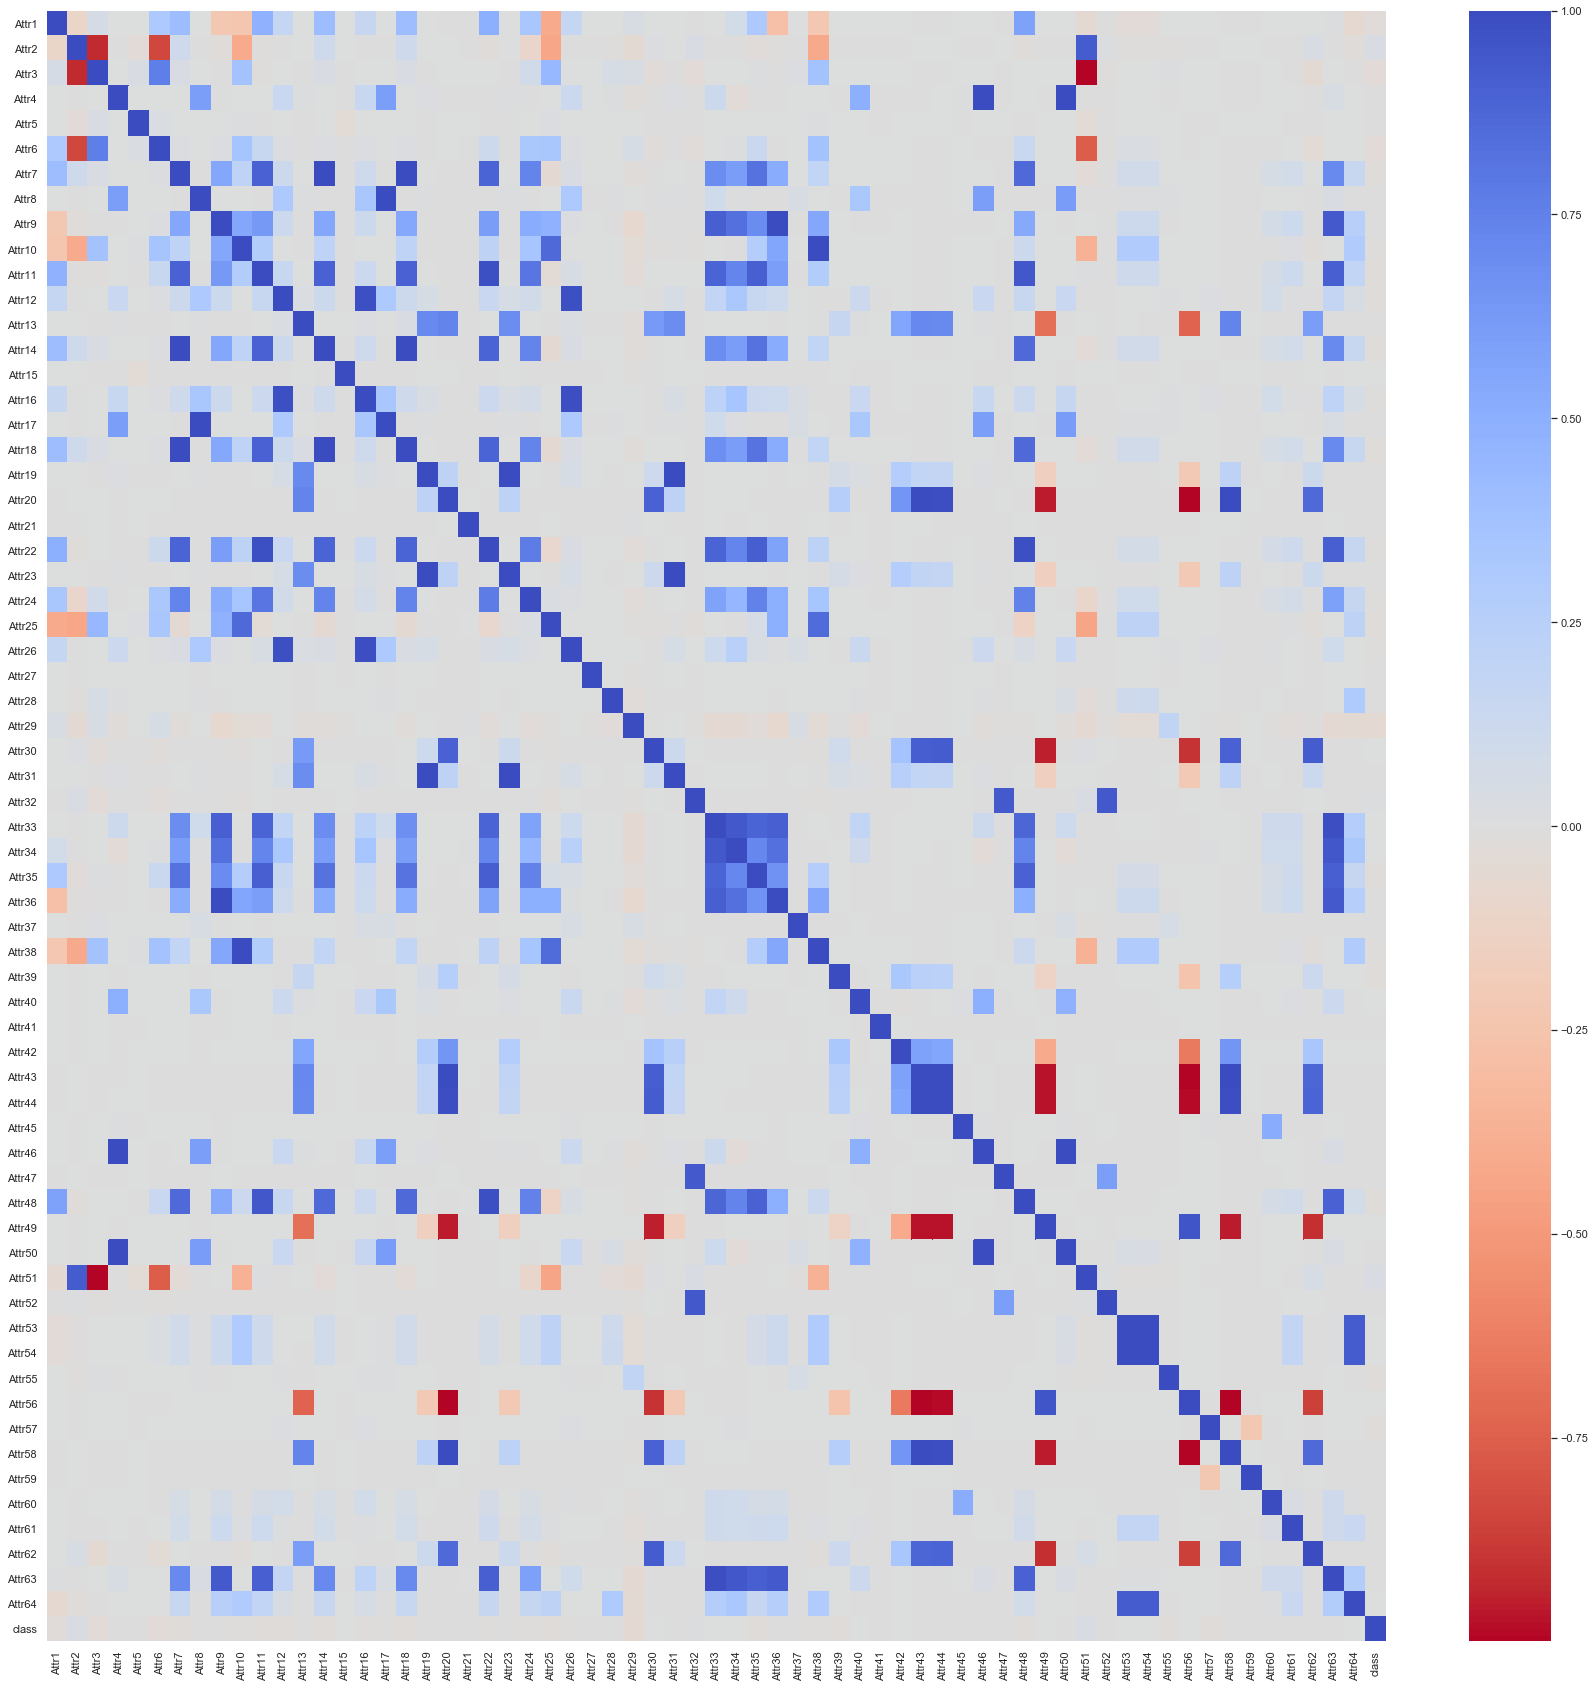

In [43]:
#Add a column callled label where 0 is for 'not bankrupt' and 1 for'bankrupt'
data['label']=data['class'].map(lambda x: 'Not bankrupt' if x==0 else 'bankrupt')

corr=data.iloc[:,:65].corr()
fig,ax=plt.subplots(1,1,figsize=(30,30))
sns.heatmap(corr,cmap='coolwarm_r',ax=ax)

#negative corrleation 2,4,7,13,17
#posive corrleation 6,10,25,


# 2. Missing Data

>Before diving into the intensive analysisn of our given data, to check out the missing valus is a key role we should take first. 




In [44]:
n_splits=5
def cv_scores(X,y):
    sm=SMOTE()
    X_over,y_over=sm.fit_sample(X,y)
    X_train,X_test,y_train,y_test=train_test_split(X_over,y_over,test_size=0.25)
    #take a turn for evaluting the performance of a model
    classifier=RandomForestClassifier()
    sc=StandardScaler()
    estimator=make_pipeline(sc,classifier)
    train_score=cross_val_score(estimator,X_train,y_train,cv=n_splits).mean()

    return train_score


### 2.1 Deletion

In [45]:
# from sklearn.pipeline import Pipeline


# #Create a Tempeporal Data
# data2=data.copy()
# data2=data2.dropna()

# X_drop=data2.iloc[:,:-2]
# y_drop=data2.iloc[:,-2]

# train_score_d=cv_scores(X_drop,y_drop)

In [46]:
# train_score_d

### 2.2 Imputing Missing Values With Group-Based Means

In [47]:
data3=data.copy()
X=data3.groupby(['class']).transform(lambda x:x.fillna(x.mean()))
X_mean_impute,y_mean_impute=X,data3.iloc[:,-2]
# train_score_m,test_score_m=cv_scores(X_mean_impute,y_mean_impute)



In [49]:
#train_score_m,test_score_m

### 2.3  KNN

In [ ]:
from sklearn.impute import KNNImputer
import sys

def missing_conversion(data):
    attrs=data.loc[:,:'Attr64'].columns
    for col,attr in enumerate(attrs):
        missing_index=np.where(data[attr].isnull())[0]
        if len(missing_index)!=0:
            data.iloc[missing_index,col]=np.nan
    return data



In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
n_splits=5
classifier=RandomForestClassifier()

def get_scores_KNN(X,y):
    imputer=KNNImputer(missing_values=np.nan)
    X_trans=imputer.fit_transform(X)
    sm=SMOTE()
    X_over,y_over=sm.fit_sample(X_trans,y)
    X_train,X_test,y_train,y_test=train_test_split(X_over,y_over,test_size=0.25)
    #take a turn for evaluting the performance of a model
    classifier=RandomForestClassifier()
    sc=StandardScaler()
    estimator=make_pipeline(sc,classifier)
    train_score=cross_val_score(estimator,X_train,y_train,cv=n_splits).mean()
    classifier.fit(X_train,y_train)
    test_score=classifier.score(X_test,y_test)
    return train_score,test_score,X_trans
    
#preapre the  data
X_knn=data.iloc[:,:-2]
y=data.iloc[:,-2]

X=missing_conversion(X_knn)


#obtain the cross-validation scores
train_score_knn,test_score_knn,X_trans_knn=get_scores_KNN(X,y)
    

In [ ]:
train_score,test_score

### 2.4 Iterative_Imputer

In [64]:

from sklearn.model_selection import GridSearchCV
def get_score_Iterative(X,y):
    sc=StandardScaler()
    imputer=IterativeImputer(missing_values=np.nan,add_indicator=True,n_nearest_features=5,sample_posterior=True,
                             initial_strategy='median')
    X_trans=imputer.fit_transform(X)
    train_score,test_score=cv_scores(X_trans,y)
    return train_score,test_score,X_trans
    
   
    
X=data.iloc[:,:-2]
y=data.iloc[:,-2]    

train_score_ir,test_score_ir,X_trans_ir=get_score_Iterative(X,y)


In [65]:
train_score_ir,test_score_ir

(0.978167175193035, 0.9821368059253521)

In [78]:
import seaborn as sns
train_scores=[train_score_d,train_score_m,train_score,train_score_ir]
test_scores=[test_score_d,test_score_m,test_score,test_score_ir]

pd.DataFrame([train_scores,test_scores],columns=['Deletion','Imputation_Mean','Imputation_KNN','Imputation_Iterative'],
             index=['Train','Test'])


,Deletion,Imputation_Mean,Imputation_KNN,Imputation_Iterative
Train,0.985496,0.988479,0.971503,0.978167
Test,0.989046,0.990221,0.975505,0.982137


> ## Final Comments
> Surprsingly, all our algorithms proves quite a higher percentage accuracy where all of them are in high 90 %. 
> Since we have apporximately the sampe performance of imputation, we will take the imputation based on group means beacuse
> it has the highest accuracy and efficiency in terms of socres, conveinience and time taken to process the imputation.  
 

In [50]:
data=pd.concat([X_mean_impute,y_mean_impute],axis=1)
fd=data.copy()

# 3. Descriptive Analaysis 



## 3.1 Liquidity




<img src="https://user-images.githubusercontent.com/53164959/81463297-86086900-91f3-11ea-9f38-f91165ed03cb.png"  alt="Drawing" style="width: 400px;"/>

>It seems to be logical and reasonable to believe that companies with a good reputation for financial health can demonstarte thier abilities to pay up the short-term liablity by liquidating the assets which are easily convertible into cash, often called current assets.So financial analysts are curious with firm's short term capacity to repay the debts - liquidating the current assets to meet the liabilities whose maturity are on average less than a year. 
>
>The most widely used ratio to see the firm's short-term sovlency is 'Quick Ratio'. This may inculude
>-  Current Assets/ Current Liablity (Attr4) is often referred to as   _Current Ratio_
>
>- (current assets - inventory - receivables) / short-term liabilities (Attr40)  or _Cash Ratio_
>
>-  (current assets - inventory) / short-term liabilities  (Attr46) or  _Acid Ratio_
>
>-  (current assets)/ total liability (Attr 50)
>
>- working capital (Attr 55) 





In [51]:
#Confirm that there measures are highly corrleated to each other
fd.corr()['Attr4'].sort_values(ascending=False)[:10]

Attr4     1.000000
Attr46    0.999920
Attr50    0.954791
Attr8     0.589277
Attr17    0.587628
Attr40    0.493623
Attr16    0.150162
Attr12    0.147836
Attr26    0.129760
Attr33    0.118596
Name: Attr4, dtype: float64

>We can also see there methos are highly relevant to evaltion of liquidity of a firm by computing correltions. Some of
>the highly correlated factors are overlapped to the ones we previously cateogrize in the liquidity section. 

### 3.1.2 Descriptive Statistics based on Two Groups

In [52]:
#store the number of columns closesly realted to each other
liquidity_columns=['Attr4','Attr40','Attr46','Attr50','Attr55']
liquidity_without_wk=['Attr4','Attr40','Attr46','Attr50']

In [53]:
print('Data Summary Class 1')
liq_br=fd[fd['class']==1][liquidity_columns].describe()
display(liq_br)

print('-'*100)
print('Data Summary Class 0')
liq_nr=fd[fd['class']==0][liquidity_columns].describe()
display(liq_nr)


Data Summary Class 1


,Attr4,Attr40,Attr46,Attr50,Attr55
count,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000
mean,4.146114,2.224849,2.947859,3.241838,790.534411
std,30.144523,22.965327,23.542008,26.594336,28636.230718
min,-0.403110,-8.833300,-0.342860,0.000000,-178810.000000
25%,0.750725,0.022878,0.289980,0.539635,-1023.050000
50%,1.084900,0.066259,0.545160,0.878410,86.140000
75%,1.651850,0.263575,1.011850,1.325650,1316.450000
max,916.500000,569.330000,577.500000,916.500000,589980.000000


----------------------------------------------------------------------------------------------------
Data Summary Class 0


,Attr4,Attr40,Attr46,Attr50,Attr55
count,41314.000000,41314.000000,41314.000000,41314.000000,4.131400e+04
mean,6.424485,2.143491,5.554395,5.966607,8.020493e+03
std,302.274398,57.108467,302.220369,314.666778,7.149613e+04
min,-0.045319,-101.270000,-101.260000,-0.045239,-1.805200e+06
25%,1.070900,0.055979,0.631792,0.792000,5.040075e+01
50%,1.606750,0.187230,1.056400,1.247450,1.171150e+03
75%,2.865475,0.682127,1.969200,2.271975,5.213950e+03
max,53433.000000,8007.100000,53433.000000,53433.000000,6.123700e+06


>From two summaries, we have a reasonable ground to detect some of outliers present in two groups.
Generally speaking, most of the financial ratios equal to 100 or even greater are considered to be highly unlikely or rare events. If you look at our descriptive summary of the listed columns, the maximum ratio of every column is a way higher than we would expect them to be optimal. These excetionallery lager valus are not devoted to enhancing the explantory power of our training alogirthm in the upcoming sections.

Int64Index([ 6126,  7417, 14330, 17063, 20259, 24088, 25111, 27458, 35384,
            37027, 38516, 42305, 42373, 43096],
           dtype='int64')


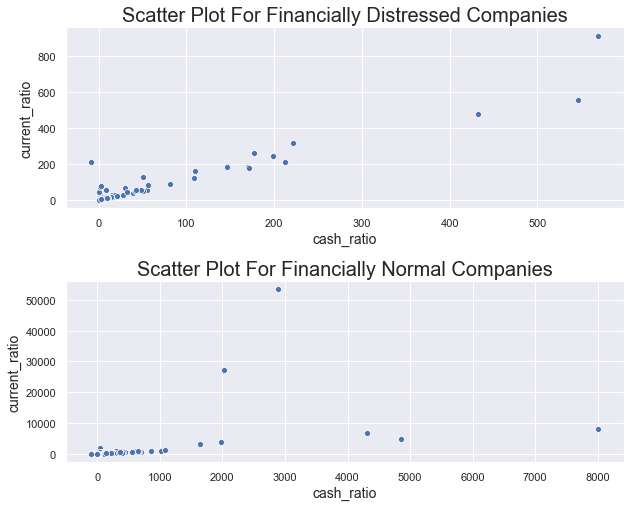

In [54]:

sns.set()
fig,axes=plt.subplots(2,1,figsize=(10,8))
temp=data[(data.loc[:,'class']==1)]
sns.scatterplot(temp.loc[:,'Attr40'],temp.loc[:,'Attr4'],ax=axes[0])
axes[0].set_xlabel('cash_ratio',fontsize=14)
axes[0].set_ylabel('current_ratio',fontsize=14)
axes[0].set_title('Scatter Plot For Financially Distressed Companies',fontsize=20)
outlier_index_1=temp[(temp.Attr40>=100)|(temp.Attr4>=100)].index



temp=data[(data.loc[:,'class']==0)]
sns.scatterplot(temp.loc[:,'Attr40'],temp.loc[:,'Attr4'],ax=axes[1])
axes[1].set_xlabel('cash_ratio',fontsize=14)
axes[1].set_ylabel('current_ratio',fontsize=14)
axes[1].set_title('Scatter Plot For Financially Normal Companies',fontsize=20)
outlier_index_2=temp[(temp.Attr40>=100)|(temp.Attr40<=-100)].index

fig.subplots_adjust(hspace=0.4)
print(outlier_index_1)

In [55]:
#print out the percentage of data loss by deletion
outlier_index=list(outlier_index_1)+list(outlier_index_2)
print(f'the percentage of lossing data by deletion: {len(outlier_index)/len(data)*100}%')


the percentage of lossing data by deletion: 0.21656491187651192%


In [56]:
#drop the outliers
outlier_index=list(outlier_index_1)+list(outlier_index_2)
fd.drop(outlier_index,axis=0,inplace=True)





,current_ratio,cash_ratio,quick_ratio,current_asset/total_liability,working_capital
class,,,,,
0,1.60475,0.186470,1.05440,1.24545,1174.45
1,1.08020,0.065078,0.54191,0.87604,79.32


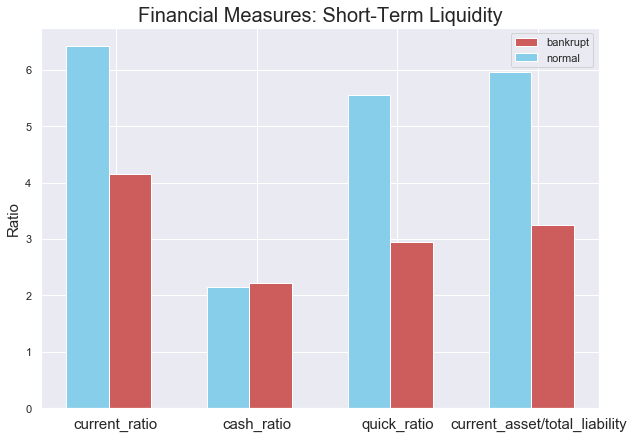

In [57]:
summary=fd.groupby('class')[liquidity_columns].median()
#Data Summary based on the median values
labels=['current_ratio','cash_ratio','quick_ratio','current_asset/total_liability','working_capital']
width=0.3
summary.columns=labels
display(summary)

fig,ax=plt.subplots(1,1,figsize=(10,7))


ax.bar(np.arange(4),liq_br.loc['mean',:'Attr50'],width=width,color='indianRed',label='bankrupt')
ax.bar(np.arange(4)-width,liq_nr.loc['mean',:'Attr50'],width=width,color='SkyBlue',label='normal')
ax.legend()
ax.set_ylabel('Ratio',fontsize=15)
ax.set_xticks(np.arange(4)-width+0.2)
ax.set_xticklabels(labels=labels,fontsize=15)
ax.set_title("Financial Measures: Short-Term Liquidity",fontsize=20)
plt.legend()

In [58]:
fd['workgin_capital_sign']=None

def computation(a):
    if a<0:
        result='negative'
    elif 0<=a<1e-3:
        result='zero'
    else:
        result='positive'
    return result

fd['working_capital_sign']=fd.Attr55.map(lambda x: computation(x))
wk=fd.pivot_table('Attr46',index=['class','working_capital_sign'],aggfunc='count')
wk['percent']=np.round(wk/wk.groupby('class').sum()*100,2)
wk.columns=['counts','percent(%)']


wk2=fd.groupby(['class','working_capital_sign'])['Attr40','Attr46','Attr50','Attr55'].median()
wk3=pd.concat([wk,wk2],axis=1)
wk3.columns=['Counts','Percent(%)','Cash-ratio','Acid-Ratio','Current_asset/Total_liability','Working_Capital']
display(wk3)

Counts  Percent(%)  Cash-ratio  Acid-Ratio  \
class working_capital_sign                                               
0     negative                8528       20.68    0.050560    0.456870   
      positive               32683       79.26    0.292320    1.313800   
      zero                      23        0.06    2.143491    5.554395   
1     negative                 894       43.04    0.032851    0.305880   
      positive                1180       56.81    0.137945    0.893050   
      zero                       3        0.14    2.224849    2.947859   

                            Current_asset/Total_liability  Working_Capital  
class working_capital_sign                                                  
0     negative                                   0.575410         -1143.40  
      positive                                   1.530700          2165.90  
      zero                                       5.966607             0.00  
1     negative                                   0.526760         -1584.20  
      positive                                   1.214750           999.49  
      zero                                       3.241838             0.00

In [59]:
#working_cpaitla_sign euqal to zero are treated as outliers
index=fd[fd.working_capital_sign=='zero'].index
fd.drop(index,axis=0,inplace=True)

> ### Finding and comments
  >From the table above, almost 80% of companies still in the businss were reported to hold the positive working captial,and  are       >following the 'right' track - the sufficient amount of cahs stored enables them to meet the imminent short-term debt at any     
   moment.
  >Their acid ratio is also compatible with the normal standard, which implies that a majority of companies are doing business    
  >efficiently and gives a positive sign to both shareholders and debtors. 
  >
  > ### What makes companies with lower liquidity either survive or declare bankruptcy?
  > The rest of the groups gives the contradictory result to what we can define as preconditions for being financially                   healthy. 
  >The 'normal' companies survived from the bankruptcy despite the indications of poor performance including negative working capital     and a relatively small portion of the cash.On the other hand, those with the simliar ratio had filed for bankruptcy or               liquidation. This seemingly strange phenomenon motivates us to look more carefully into other related measures. 
  >dropout candates: cash-ratio,current ratio,working_captial
   

## 2.2 Solvency 

### Ternminlogy 


![image](https://user-images.githubusercontent.com/53164959/81463274-4f325300-91f3-11ea-8528-f33b2cf80092.png)

>Closely concerned with liquidity is the concept of solvency - a firm's ability to meet not only its short-term obligation but also the long term one. The relevant ratio is a relation of a company's long term debt to either its assets or equity.
Some of unexpceted events are really happening in the section of long-term debt to equity ratio. According to the general practice, 
investors put into thier interest list the shares of companies whose debt to equity ratio is between 0.3 and 0.6 where below 0.4 is 
considred better. Regardless of group types, almost all the number of companies have low debt ratios somewhere around 0,which is a clear alarming sign of the inability to borrow money and a higher financial risk. Carrying too little debt also implies firms does not finance the increased operations through borrowing at all, which limits the return that can be realized or passed onto the shareholdres.
>
>The relevant measures include
> 1) Debt to Equity
> 2) Debt to Asset
> 3) Equity to Total liability
> 4) EBITDA to Total assets
> so on


balance sheet realted : Attr2,Attr6,Attr8,Attr51,Attr59

interest coverage :Attr1,Attr7

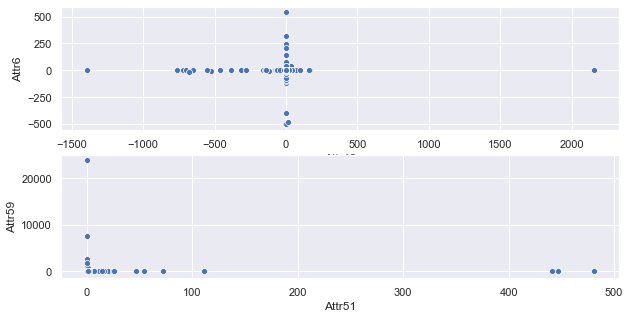

In [60]:
#remove outlirs 
fig,axes=plt.subplots(2,1,figsize=(10,5))
sns.scatterplot(fd['Attr42'],fd['Attr6'],ax=axes[0])
sns.scatterplot(fd['Attr51'],fd['Attr59'],ax=axes[1])

In [61]:
index1=fd[(fd.Attr6<-200)|(fd.Attr42>500)|(fd.Attr6>400)|(fd.Attr6<-200)].index
index2=fd[fd.Attr59>40].index
index=list(index1)+list(index2)
print(f'the percentage of outliers: {np.round(len(index)/len(fd)*100,2)} %')
fd.drop(index,axis=0,inplace=True)

the percentage of outliers: 0.18 %


In [62]:
bs_solvency=['Attr2','Attr6','Attr8','Attr51','Attr59']
ic_solvency=['Attr1','Attr7']

solvency=fd.groupby(['class','working_capital_sign'])[bs_solvency].median()
solvency.columns=['net_profit/total_asset','retained_earning/total_assets','equity/liablities','short-term liabilities/assets','long-term liabilites/equity']
solvency

net_profit/total_asset  \
class working_capital_sign                           
0     negative                             0.75391   
      positive                             0.39183   
1     negative                             0.84638   
      positive                             0.53238   

                            retained_earning/total_assets  equity/liablities  \
class working_capital_sign                                                     
0     negative                                   0.000000            0.30415   
      positive                                   0.000000            1.49365   
1     negative                                  -0.034572            0.16709   
      positive                                   0.000000            0.84519   

                            short-term liabilities/assets  \
class working_capital_sign                                  
0     negative                                    0.58715   
      positive                                    0.28344   
1     negative                                    0.70760   
      positive                                    0.39471   

                            long-term liabilites/equity  
class working_capital_sign                               
0     negative                                 0.065608  
      positive                                 0.003807  
1     negative                                 0.000000  
      positive                                 0.000000

In [63]:

solvency['liabilities/equity']=1/solvency['equity/liablities']
solvency['short-term liabilities/equity']=solvency.iloc[:,-1]-solvency.iloc[:,-2]
names=[5,4,6]
solvency.iloc[:,names]

liabilities/equity  long-term liabilites/equity  \
class working_capital_sign                                                    
0     negative                        3.287851                     0.065608   
      positive                        0.669501                     0.003807   
1     negative                        5.984799                     0.000000   
      positive                        1.183166                     0.000000   

                            short-term liabilities/equity  
class working_capital_sign                                 
0     negative                                   3.222243  
      positive                                   0.665693  
1     negative                                   5.984799  
      positive                                   1.183166

> ## Findings and Comments
<img src="https://user-images.githubusercontent.com/53164959/82113187-0cdaba00-978f-11ea-9623-2da96efa1179.png"  alt="Drawing" style="width: 300px;"/>
>  
  let's first compare those two groups with maintaining negative working captial. The amount of debt two groups have is quite
  larger than that of groups with positive working capital.However, The ratio of the debt the troubled companies have is       twice 
  greater than the one with the similar liquidity position and suprisingly almost six times greater than the surviving  comapnies       with a strong position. We here acquire a leesson that we must watch the amount of debt companies borrow!
 

## 3.3 Profitability

In [64]:
final=fd[fd.working_capital_sign!='zero'].groupby(['class','working_capital_sign'])['Attr1','Attr39','Attr31','Attr19','Attr56'].median()
final.columns=['return on assets','profit/sales','(gross_profit+interst)/sales',' gross profit / sales','(sales - cost of products sold) / sales']

In [65]:
display(final)

return on assets  profit/sales  \
class working_capital_sign                                   
0     negative                      0.009182      0.015306   
      positive                      0.067913      0.046829   
1     negative                     -0.048608     -0.028068   
      positive                      0.017209      0.017185   

                            (gross_profit+interst)/sales  \
class working_capital_sign                                 
0     negative                                  0.013354   
      positive                                  0.055643   
1     negative                                 -0.021704   
      positive                                  0.017626   

                             gross profit / sales  \
class working_capital_sign                          
0     negative                           0.007991   
      positive                           0.048564   
1     negative                          -0.029984   
      positive                           0.011073   

                            (sales - cost of products sold) / sales  
class working_capital_sign                                           
0     negative                                             0.021433  
      positive                                             0.064944  
1     negative                                            -0.006834  
      positive                                             0.029736

> Now,we could at last find some partial factors caussing  business failures.
  First, return on assets and equity is much lesser than the comparable groups on the other side. Companies holding negative working   capital scored all the negative profits across the five sction. The ratios of financially distressed companies earned twice at       minium or five times at a maximum less than the comparable ones.

  

## 4.Outliers



### 4.1Detecting Outliers

>Through analyzing the major financial ratios,we could take away the 1% of outliers from the whole data but just wonder if they still exist in the data set.

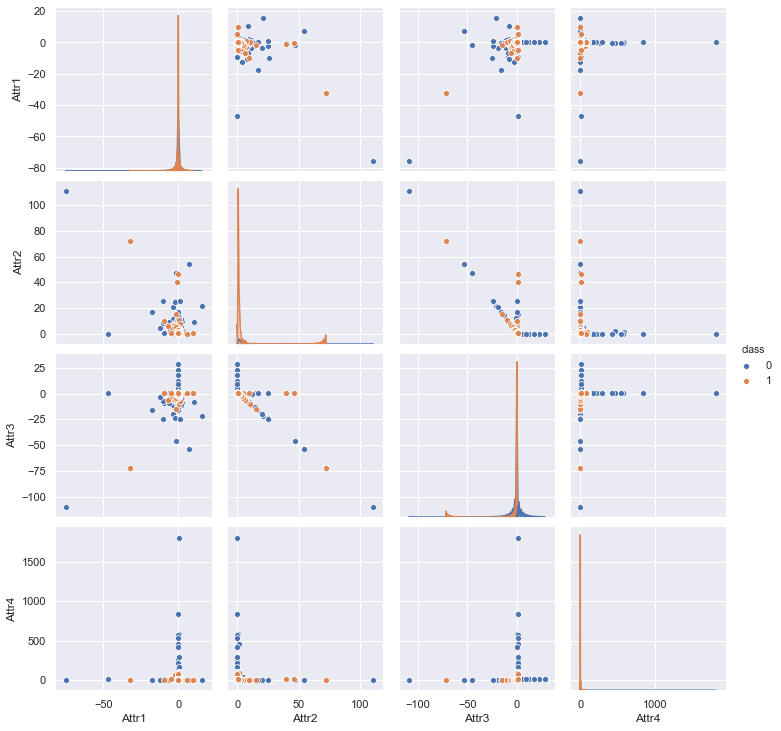

In [66]:
s=fd.loc[:,["Attr1","Attr2","Attr3","Attr4",'class']]
sns.pairplot(s,hue='class')


>There are quite a lot of factros accross the given scatter plots. Since the number of data input features we deal with are quite high, identifying the extreme values by graphiing our data for 64 times would be time consuming. Theforer, we should consider taking a machine learning approach to deal with them. The most commonly and widely used techniques for handling the outliers are following;
>
>- LocalOutlierFactor
>- Isolation Forest
>- K means
>- DBSCAN
>
>
>In this project,we will only introduce two popualr non-parametric approches dealing with outliers detection, isolation forest and localoutlier factors. 


### 4.2 Isolation Forest

>Isolation Forest is an unsupervised learning algorithms for anomaly detection. The algorithm is based on the Decision Tree algorithm and the mechanism is quite simple and this follows that randomly select a feature from the given set of features and randomly select a split values between min and max values of the chosen feature. This random partition of
features will produce shorter paths in trees for the anomalous data point,distinguishing them from the rest of points.



In [67]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


fd=fd.reset_index().drop('index',axis=1)
X=fd.copy()
X_s=X.loc[:,:'Attr64']
clf=IsolationForest(n_estimators=100,max_samples=0.25,contamination=0.003,n_jobs=-1,random_state=10)
clf.fit(X_s)
pred=clf.predict(X_s)
X['annomaly_isolationForest']=pred


In [68]:
outlier_index_1=X[X['annomaly_isolationForest']==-1].index
bankrupt_index=X[X['class']==1].index
#store the index of -1 value
X['annomaly_isolationForest'].value_counts()



 1    43077
-1      130
Name: annomaly_isolationForest, dtype: int64

> Before implementing PCA,make sure that data on which the PCA-transformation is calculated should be normalized meaning in this case
> zero mean and a unit variance.This basically is StandardScaler library which I would prefer of our candidates
>
>Anoter key point is that before doing any types of scaling in your mind,drop outliers as much as possible in order to obatin the
>statsifactory level of the feature deimension

In [27]:
sc=StandardScaler()
X_stand=sc.fit_transform(X.loc[:,:'Attr64'])
pca=PCA(n_components=10)
X_pca=pca.fit_transform(X_stand)

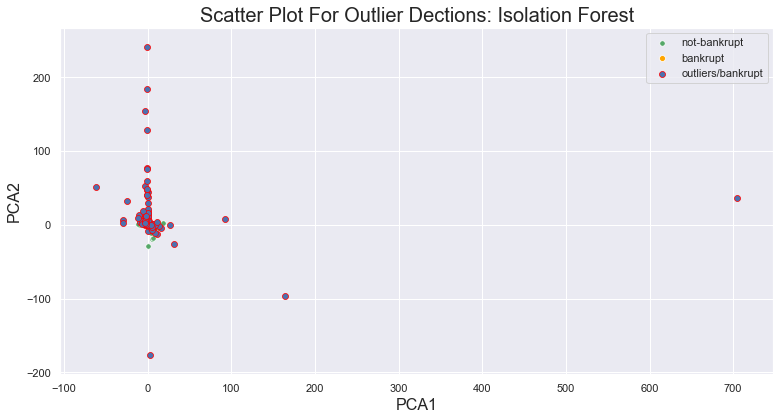

In [28]:
sns.set()
fig,ax=plt.subplots(figsize=(11,6))
sns.scatterplot(X_pca[:,0],X_pca[:,1],color='g',label='not-bankrupt',s=30,ax=ax)
sns.scatterplot(X_pca[bankrupt_index,0],X_pca[bankrupt_index,1],color='orange',label='bankrupt',ax=ax)
sns.scatterplot(X_pca[outlier_index_1,0],X_pca[outlier_index_1,1],edgecolor='red',label='outliers/bankrupt',ax=ax)
ax.set_xlabel('PCA1',fontsize=16)
ax.set_ylabel('PCA2',fontsize=16)
ax.set_title('Scatter Plot For Outlier Dections: Isolation Forest',fontsize=20)
plt.legend()
fig.tight_layout()

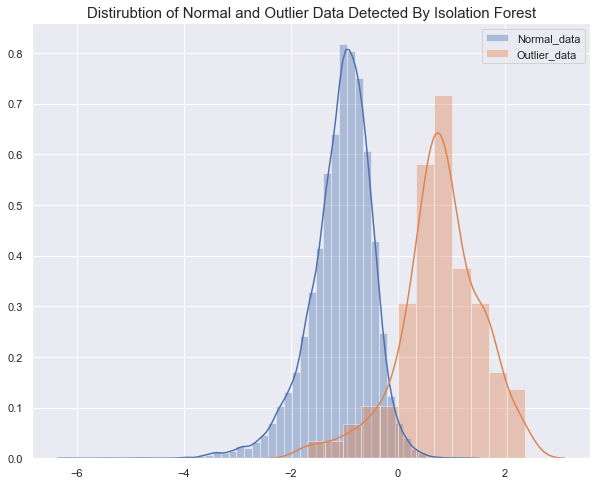

In [406]:
normal_index_is=[i for i in fd.index if i not in outlier_index_1]
X_normal=X_pca[normal_index_is,:]
X_abnormal=X_pca[outlier_index_1,:]
fig,ax=plt.subplots(figsize=(10,8))
sns.distplot(np.log10(X_normal[:,0]),label='Normal_data',ax=ax)
sns.distplot(np.log10(X_abnormal[:,1]),label='Outlier_data',ax=ax)
ax.set_title("Distirubtion of Normal and Outlier Data Detected By Isolation Forest",fontsize=15)
plt.legend()


### 4.3 Local Outlier Factor

>This algorithm measures the local deviation of density of a given sample with repsect to its neighbors. To predict whether it is local or not highly depends on how isolated the object is with respect to the surrounding neighbors. 

In [407]:
from sklearn.neighbors import LocalOutlierFactor
lc=LocalOutlierFactor(n_neighbors=20,algorithm='auto',contamination=0.003)
X['annomaly_localOutlier']=lc.fit_predict(X_s)

outlier_index_2=X[X['annomaly_localOutlier']==-1].index
bankrupt_index_2=X[X['class']==1].index
#store the index of -1 value
X['annomaly_localOutlier'].value_counts()


 1    43077
-1      130
Name: annomaly_localOutlier, dtype: int64

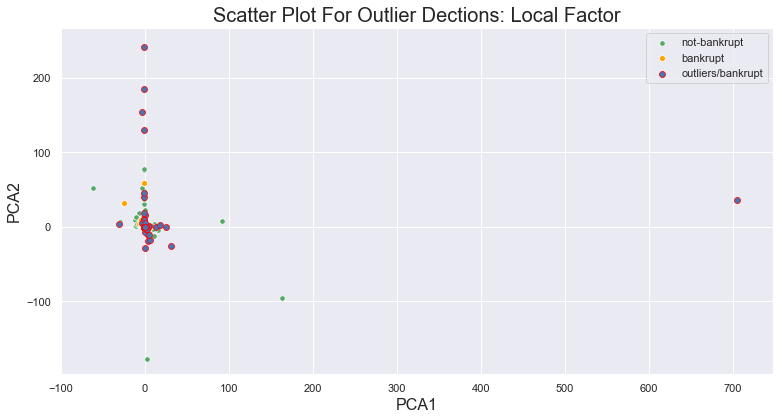

In [408]:
sns.set()
fig,ax=plt.subplots(figsize=(11,6))
sns.scatterplot(X_pca[:,0],X_pca[:,1],color='g',label='not-bankrupt',s=30,ax=ax)
sns.scatterplot(X_pca[bankrupt_index,0],X_pca[bankrupt_index,1],color='orange',label='bankrupt',ax=ax)
sns.scatterplot(X_pca[outlier_index_2,0],X_pca[outlier_index_2,1],edgecolor='red',label='outliers/bankrupt',ax=ax)
ax.set_xlabel('PCA1',fontsize=16)
ax.set_ylabel('PCA2',fontsize=16)
ax.set_title('Scatter Plot For Outlier Dections: Local Factor',fontsize=20)
plt.legend()
fig.tight_layout()

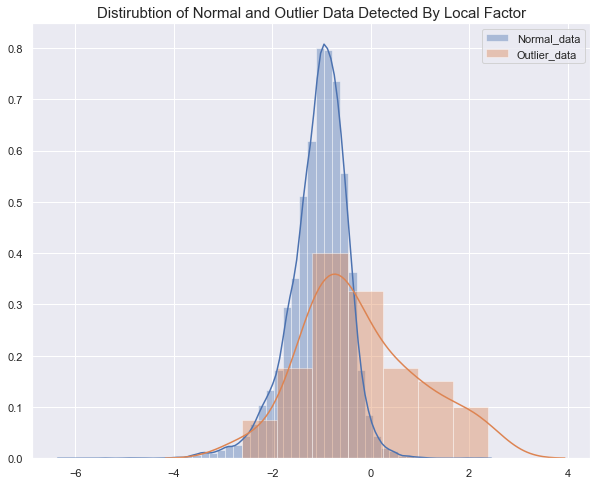

In [409]:
normal_index=[i for i in fd.index if i not in outlier_index_2]
X_normal=X_pca[normal_index,:]
X_abnormal=X_pca[outlier_index_2,:]
fig,ax=plt.subplots(figsize=(10,8))
sns.distplot(np.log10(X_normal[:,0]),label='Normal_data')
sns.distplot(np.log10(X_abnormal[:,1]),label='Outlier_data')
ax.set_title("Distirubtion of Normal and Outlier Data Detected By Local Factor",fontsize=15)
plt.legend()

### 4.4 One Support VectorMachine

In [410]:
from sklearn.svm import OneClassSVM

In [411]:
svm=OneClassSVM(kernel='rbf',nu=0.003,gamma=0.03)
X['annomaly_oneSVM']=lc.fit_predict(X_s)

In [412]:
pred3=svm.fit_predict(X_trans)
outlier_index_3=X[X['annomaly_oneSVM']==-1].index
X.annomaly_oneSVM.value_counts()

 1    43077
-1      130
Name: annomaly_oneSVM, dtype: int64

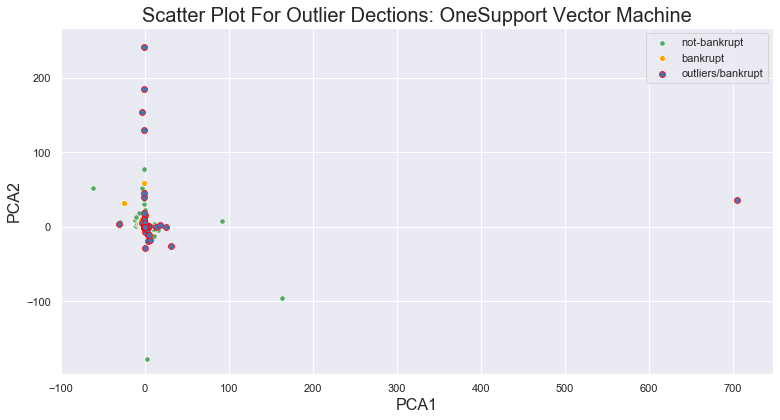

In [413]:
sns.set()
fig,ax=plt.subplots(figsize=(11,6))
sns.scatterplot(X_pca[:,0],X_pca[:,1],color='g',label='not-bankrupt',s=30,ax=ax)
sns.scatterplot(X_pca[bankrupt_index,0],X_pca[bankrupt_index,1],color='orange',label='bankrupt',ax=ax)
sns.scatterplot(X_pca[outlier_index_3,0],X_pca[outlier_index_3,1],edgecolor='red',label='outliers/bankrupt',ax=ax)
ax.set_xlabel('PCA1',fontsize=16)
ax.set_ylabel('PCA2',fontsize=16)
ax.set_title('Scatter Plot For Outlier Dections: OneSupport Vector Machine',fontsize=20)
plt.legend()
fig.tight_layout()

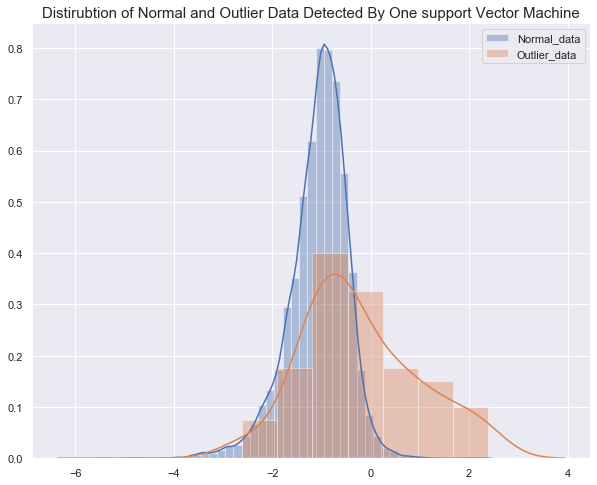

In [414]:
normal_index=[i for i in fd.index if i not in outlier_index_3]
X_normal=X_pca[normal_index,:]
X_abnormal=X_pca[outlier_index_3,:]
fig,ax=plt.subplots(figsize=(10,8))
sns.distplot(np.log10(X_normal[:,0]),label='Normal_data')
sns.distplot(np.log10(X_abnormal[:,1]),label='Outlier_data')
ax.set_title("Distirubtion of Normal and Outlier Data Detected By One support Vector Machine",fontsize=15)
plt.legend()

### 4.5 Removing Outliers

>From the tree distributions, we have done,  there is no hesitation to choose the isolation method for the two following reasons.
>
>First, the number of 'deemed' outliers detected by isolation is relatively smaller than by the other two. Later in this section, we will proceed to create Variational Auto Encoder , one of the deep learning techniques, and the more data we have to train our model, the better accuracy we can obtain.
>
>We can see there are two distinct distributions under the isolation forest even though the perfect separation seems to be impossible.
The other two do not give much help to detect the outliers in that distributions of two separate groups almost overlap with each other.
>
>From the given information, we will remove the outliers according the index of outliers assigned by isolation forest.

In [69]:
#delete outliers
fd.drop(outlier_index_1,axis=0,inplace=True)

## 5. Features Engineering

### 5.1 Feature Seletion




In [134]:
fs=fd.copy()
X,y=fs.iloc[:,:-3],fs.iloc[:,-3]
print(len(X))
print(len(y))

43077
43077


## 5.1.1 univariate Selection

Univariate feature selection examines each feature individually to determine the strength of the relationship of the feature with the response variable.The major mechanism behind this is to select the input feature whose variance within the group is small but between groups is high. The major metirc for scoring features is Chi-square or F-test. In our case, we will use F-value.

![image](https://user-images.githubusercontent.com/53164959/83027597-405cf480-a06b-11ea-9470-702ff97035c6.png)

One thing concerns here is to select the optimal number of K where its selection is neither predefined nor absolute.
Therfore, the best practice here is either trying or intitively.


In [4]:
from sklearn.feature_selection import SelectKBest,f_classif
import sys
from collections import defaultdict


results=defaultdict(float)
sc=StandardScaler()
X_scal=sc.fit_transform(X)
for i in range(10,26):
    sb=SelectKBest(f_classif,k=i).fit(X_scal,y)
    X_trans=sb.fit_transform(X_scal,y)
    cl=RandomForestClassifier()
    val_score=cross_val_score(cl,X_trans,y,cv=5).mean()
    result[i]=val_score

The optimal n feature:19

The maxium accuracy of the training:0.9503447315272652


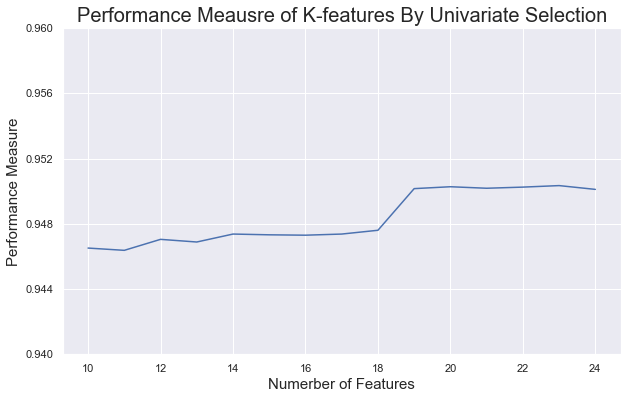

In [684]:

fig,ax=plt.subplots(figsize=(10,6))
a,b=list(results.keys()),list(results.values())
sns.lineplot(a,b,ax=ax)
ax.set_yticks(np.linspace(0.94,0.96,6))
ax.set_ylabel('Performance Measure',fontsize=15)
ax.set_xlabel('Numerber of Features',fontsize=15)
ax.set_title('Performance Meausre of K-features By Univariate Selection',fontsize=20)


print(f'The optimal n feature:{19}')
print('')
print(f'The maxium accuracy of the training:{max(results.values())}')

## 5.1.2 Recursive Feature Elimination with cross_validation(RFE) 

This is one of the backward methods,which all variables are included and the specified number of factors are removed on each iteration.Basically, this methods uses one of many classifiers and the asssign weights to each input in the given dataset.The model select the lowest absolute value of weight and remove it from the current set features. This step keeps being repeated until meeting the
predefined criterion. 

In [633]:
# from sklearn.feature_selection import RFECV

# cl=RandomForestClassifier()
# rfecv=RFECV(estimator=cl,step=1,cv=5,scoring='accuracy')
# rfecv=rfecv.fit(X,y)

In [660]:
print(f'The optimal n feature:{rfecv.n_features_}')
print('')
print(f'The selected colums are{X.columns[rfecv.support_]}')
print('')
print(f'The maxium accuracy of the training:{max(rfecv.grid_scores_)}')

The optimal n feature:9

The selected colums areIndex(['Attr5', 'Attr21', 'Attr24', 'Attr27', 'Attr34', 'Attr37', 'Attr46',
       'Attr58', 'Attr59'],
      dtype='object')

The maxium accuracy of the training:0.988276814693984


Text(0.5, 1.0, 'Performance Meausre of K features by RFE with CV')

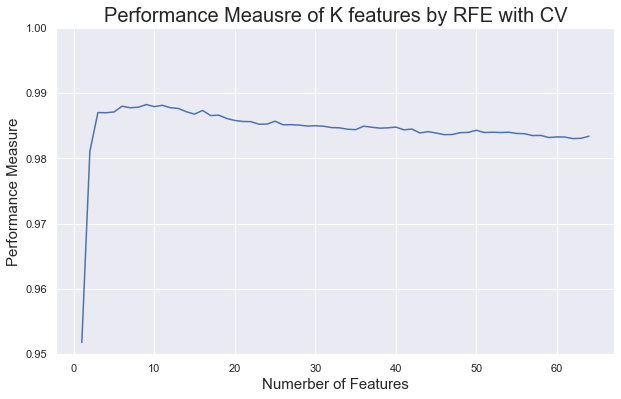

In [655]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(range(1,len(rfecv.grid_scores_)+1),rfecv.grid_scores_,ax=ax)
ax.set_yticks(np.linspace(0.95,1,6))
ax.set_ylabel('Performance Measure',fontsize=15)
ax.set_xlabel('Numerber of Features',fontsize=15)
ax.set_title('Performance Meausre of K features by RFE with CV',fontsize=20)

### 5.3 Tree Based Feature Selection

>In skitlearn, a majority of tree based models provide featureimportance attributes which assigns evey input scores according to its importance in imporvoing prediction accuracy.There are a couple of things we should bear in mind before implementing tree based models.
>
>First,either scaling or normalizing input attributes are not required before running the model. This is primarily beacuse convergence and numerical precision are not so important. Also, we don't get any analogue of a regression coeffieicnt,which measures the relationship between each predictor variables and the response. Because of this,we dont need to consider how to interpret the coefficients that are heavily affected by variable measurement scales.
>
>Second,make sure that all features are not strognly correlated to each other. Let's put the issues of collinearity as a major
 problems of taking highly correlated features for a while. Just imagine we run a model based on 'redudant' infomration. Right
 after one of the corrleated factor is used at the lower level of the tree, then the amount of impurity the next related data can remove is very high likely to be lower and the model shoould give a less imporatance on the latter use accordingly. This is fine 
 as long as we use the tree algorithms for the feature selection.Bu when interpreting the data, it can lead to the incorrect conlusion that one of the variables is a stronger predictor while the others in the same groups are considered less important although they are very close in terms of thier relationship with the response vairables.

In [733]:
columns=X.columns
corr_data=X.corr()

for column in columns:
    try:
        rd=corr_data[column][(np.abs(corr_data[column])>0.7)&(np.abs(corr_data[column]<1.0))].index
        columns=columns.drop(rd)
    except:
        pass
    
print(f'The total number of input features after removing the correlated features:{len(columns)}')
X_trans=X.loc[:,columns]

The total number of input features after removing the correlated features:29


In [735]:
clf=RandomForestClassifier()
clf=clf.fit(X_trans,y)
index_high_order=np.argsort(clf.feature_importances_)[::-1]
index_high_order

array([16, 10, 25,  9, 24, 17, 12,  6, 22,  1, 20,  5, 11,  7, 18, 28, 13,
        0,  4,  2, 23, 26,  3, 27, 14,  8, 21, 15, 19], dtype=int64)

In [740]:
results=list()
for i in range(8,16):
    X_select=X.iloc[:,index_high_order[:i]]
    clf=clf.fit(X_select,y)
    val_score=cross_val_score(clf,X_select,y,cv=5,scoring='accuracy').mean()
    results.append(val_score)

Text(0.5, 1.0, 'Performance Meausre of K features by Random Forest')

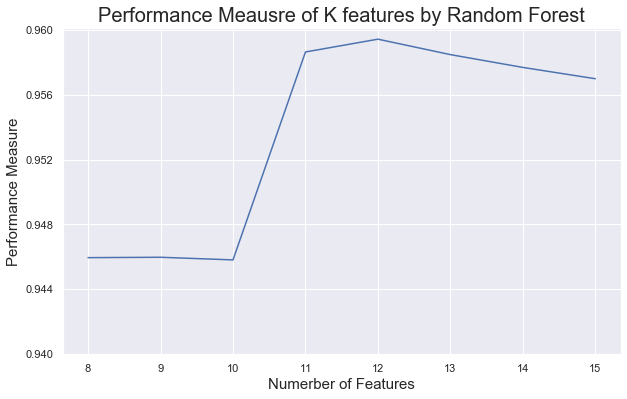

In [744]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(np.arange(8,16),results)
ax.set_yticks(np.linspace(0.94,0.96,6))
ax.set_ylabel('Performance Measure',fontsize=15)
ax.set_xlabel('Numerber of Features',fontsize=15)
ax.set_title('Performance Meausre of K features by Random Forest',fontsize=20)

### 5.2 Feature Extraction

The core theme of PCA is to produce a linear combination of input features to create new dimensions. PCA arranges these new components according to the size of variance. Before runing PCA, normalizing our data is a key step we must not ignore. 
Remember a bigger scale always create bigger values and squre of a bigger values grows fatster.But it does not mean that the input feature with a bigger scale carry significantly more infomration compared to with a less scale. Without a proper normalization, pca would give a high weight to the large-unit feature, which leads to an unfair comparasion between the explained variance in the dataset


In [31]:
sc=StandardScaler()
X_trans=sc.fit_transform(X)
pca=PCA(n_components=20)
X_pca=pca.fit_transform(X_trans)



Text(0.5, 1.0, 'Variance accross K features by PCA')

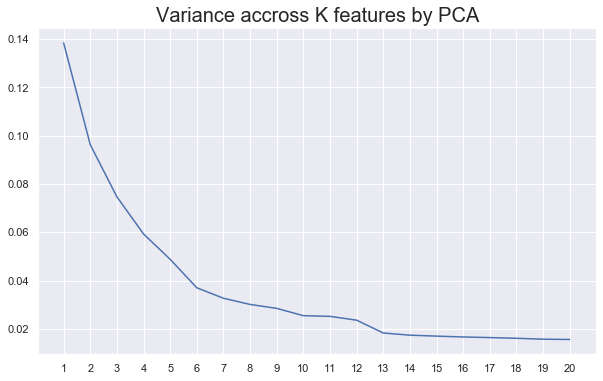

In [32]:
fig,ax=plt.subplots(figsize=(10,6))
sns.lineplot(np.arange(len(pca.explained_variance_)),pca.explained_variance_ratio_)
ax.set_xticks(np.arange(0,len(pca.explained_variance_ratio_)+1))
ax.set_xticklabels(np.arange(1,len(pca.explained_variance_ratio_)+1))
ax.set_title('Variance accross K features by PCA',fontsize=20)

### 6. Choosing Features and Saving The Data

In [73]:
selected_features=['Attr5', 'Attr21', 'Attr24', 'Attr27', 'Attr34', 'Attr37', 'Attr46',
        'Attr58', 'Attr59']

In [74]:
#Only include the features chosen we found in RFECV
X_selected=X.loc[:,selected_features]
data_selected=pd.concat([X_selected,y],axis=1)

mem =memory.Memory(cachedir='/cache')
data_selected.to_csv('/cache/data_selected.csv')